# Two-Stage Next-Basket Recommender (XGBoost)

This notebook builds a two-stage recommender for Instacart next-basket prediction.

- Stage 1 generates a candidate set from each user's prior purchases.
- Stage 2 scores candidates with an XGBoost classifier using user, product, and user-product features.


We report ROC-AUC/LogLoss plus top-K Precision, Recall, and F1 on a user-split validation set,
and then produce test-order recommendations.

## 1) Imports and Settings
Ensure `xgboost` is installed in your environment before running.

In [20]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = Path('..') / 'data'
SEED = 42

## 2) Load Data

In [3]:
orders = pd.read_csv(DATA_DIR / 'orders.csv')
prior = pd.read_csv(DATA_DIR / 'order_products__prior.csv')
train = pd.read_csv(DATA_DIR / 'order_products__train.csv')
products = pd.read_csv(DATA_DIR / 'products.csv')

## 3) Feature Engineering
We compute user, product, and user-product features from prior data.

In [4]:
# Merge prior with orders to get user_id and order_number
prior = prior.merge(orders[['order_id', 'user_id', 'order_number']], on='order_id', how='left')
prior['order_number'] = prior['order_number'].astype(np.int16)

In [5]:
# User features
user_features = orders.groupby('user_id').agg(
    user_total_orders=('order_number', 'max'),
    user_avg_days_since_prior=('days_since_prior_order', 'mean'),
).reset_index()
user_reorder = prior.groupby('user_id')['reordered'].mean().reset_index(name='user_reorder_ratio')
user_features = user_features.merge(user_reorder, on='user_id', how='left')
user_features['user_avg_days_since_prior'] = user_features['user_avg_days_since_prior'].fillna(0.0).astype(np.float32)
user_features['user_reorder_ratio'] = user_features['user_reorder_ratio'].fillna(0.0).astype(np.float32)

In [6]:
# Product features
prod_features = prior.groupby('product_id').agg(
    prod_total_purchases=('order_id', 'count'),
    prod_reorder_prob=('reordered', 'mean'),
).reset_index()
prod_features['prod_total_purchases'] = prod_features['prod_total_purchases'].astype(np.int32)
prod_features['prod_reorder_prob'] = prod_features['prod_reorder_prob'].astype(np.float32)
prod_features = prod_features.merge(products[['product_id', 'aisle_id', 'department_id']], on='product_id', how='left')

In [7]:
def compute_streak(order_numbers):
    order_numbers = np.sort(order_numbers)
    if order_numbers.size == 0:
        return 0
    streak = 1
    for i in range(order_numbers.size - 2, -1, -1):
        if order_numbers[i] == order_numbers[i + 1] - 1:
            streak += 1
        else:
            break
    return streak

In [8]:
# User-product interaction features
up = prior.groupby(['user_id', 'product_id']).agg(
    up_total_orders=('order_id', 'count'),
    up_avg_position=('add_to_cart_order', 'mean'),
    up_last_order_number=('order_number', 'max'),
).reset_index()
up['up_avg_position'] = up['up_avg_position'].astype(np.float32)
up = up.merge(user_features[['user_id', 'user_total_orders']], on='user_id', how='left')
up['up_order_rate'] = up['up_total_orders'] / up['user_total_orders']
up['up_orders_since_last'] = up['user_total_orders'] - up['up_last_order_number']
up['up_orders_since_last'] = up['up_orders_since_last'].astype(np.int16)
up['up_order_rate'] = up['up_order_rate'].astype(np.float32)
# Streak can be slow on full data; keep it but comment out if needed
up_streak = prior.groupby(['user_id', 'product_id'])['order_number'].apply(compute_streak).reset_index(name='up_streak')
up = up.merge(up_streak, on=['user_id', 'product_id'], how='left')
up['up_streak'] = up['up_streak'].fillna(0).astype(np.int16)
up = up.drop(columns=['user_total_orders'])

## 4) Build Training Set
Candidates are all prior products for each user in the train set.

In [9]:
train_orders = orders[orders['eval_set'] == 'train'][['order_id', 'user_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
user_prior = prior[['user_id', 'product_id']].drop_duplicates()
train_candidates = train_orders[['order_id', 'user_id']].merge(user_prior, on='user_id', how='left')
train_labels = train.merge(orders[['order_id', 'user_id']], on='order_id', how='left')
train_labels = train_labels[['user_id', 'product_id']].drop_duplicates()
train_candidates = train_candidates.merge(train_labels, on=['user_id', 'product_id'], how='left', indicator=True)
train_candidates['label'] = (train_candidates['_merge'] == 'both').astype(np.int8)
train_candidates = train_candidates.drop(columns=['_merge'])

In [10]:
# Merge features
train_df = train_candidates.merge(up, on=['user_id', 'product_id'], how='left')
train_df = train_df.merge(user_features, on='user_id', how='left')
train_df = train_df.merge(prod_features, on='product_id', how='left')
train_df = train_df.merge(train_orders, on=['order_id', 'user_id'], how='left')
train_df['days_since_prior_order'] = train_df['days_since_prior_order'].fillna(0.0).astype(np.float32)

## 5) Train XGBoost Ranker (Classifier)
We split users for validation to reduce leakage between train and validation.

In [11]:
feature_cols = [
    'up_total_orders', 'up_order_rate', 'up_avg_position', 'up_orders_since_last', 'up_streak',
    'user_total_orders', 'user_avg_days_since_prior', 'user_reorder_ratio',
    'prod_total_purchases', 'prod_reorder_prob', 'aisle_id', 'department_id',
    'order_dow', 'order_hour_of_day', 'days_since_prior_order',
]
train_df[feature_cols] = train_df[feature_cols].fillna(0)
users = train_df['user_id'].unique()
train_users, valid_users = train_test_split(users, test_size=0.2, random_state=SEED)
train_mask = train_df['user_id'].isin(train_users)
valid_mask = train_df['user_id'].isin(valid_users)
X_train = train_df.loc[train_mask, feature_cols]
y_train = train_df.loc[train_mask, 'label']
X_valid = train_df.loc[valid_mask, feature_cols]
y_valid = train_df.loc[valid_mask, 'label']

In [12]:
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    random_state=SEED,
)
model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [13]:
valid_preds = model.predict_proba(X_valid)[:, 1]
auc = roc_auc_score(y_valid, valid_preds)
ll = log_loss(y_valid, valid_preds)
print(f'AUC: {auc:.4f}  LogLoss: {ll:.4f}')

AUC: 0.8337  LogLoss: 0.2444


In [14]:
# Top-K evaluation on validation users
valid_df = train_df.loc[valid_mask, ['user_id', 'product_id', 'label'] + feature_cols].copy()
valid_df['pred'] = model.predict_proba(valid_df[feature_cols])[:, 1]


def metrics_at_k(df, k):
    precisions, recalls, f1s = [], [], []
    for user_id, group in df.groupby('user_id'):
        true_items = set(group.loc[group['label'] == 1, 'product_id'])
        if not true_items:
            continue
        topk = group.sort_values('pred', ascending=False).head(k)
        recs = topk['product_id'].tolist()
        hits = len(set(recs) & true_items)
        precision = hits / len(recs) if recs else 0.0
        recall = hits / len(true_items) if true_items else 0.0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    return np.mean(precisions), np.mean(recalls), np.mean(f1s)


results = []
for k in [5, 10, 15, 20]:
    p, r, f = metrics_at_k(valid_df, k)
    results.append({
        'K': k,
        'Precision@K': round(p, 4),
        'Recall@K': round(r, 4),
        'F1@K': round(f, 4),
        'AUC': round(auc, 4),
    })
    print(f'K={k:2d}  |  Precision@K={p:.4f}  |  Recall@K={r:.4f}  |  F1@K={f:.4f}  |  AUC={auc:.4f}')

results_df = pd.DataFrame(results)
results_df

K= 5  |  Precision@K=0.4145  |  Recall@K=0.4074  |  F1@K=0.3515  |  AUC=0.8337
K=10  |  Precision@K=0.3282  |  Recall@K=0.5808  |  F1@K=0.3666  |  AUC=0.8337
K=15  |  Precision@K=0.2795  |  Recall@K=0.6894  |  F1@K=0.3545  |  AUC=0.8337
K=20  |  Precision@K=0.2468  |  Recall@K=0.7629  |  F1@K=0.3373  |  AUC=0.8337


,K,Precision@K,Recall@K,F1@K,AUC
0,5,0.4145,0.4074,0.3515,0.8337
1,10,0.3282,0.5808,0.3666,0.8337
2,15,0.2795,0.6894,0.3545,0.8337
3,20,0.2468,0.7629,0.3373,0.8337


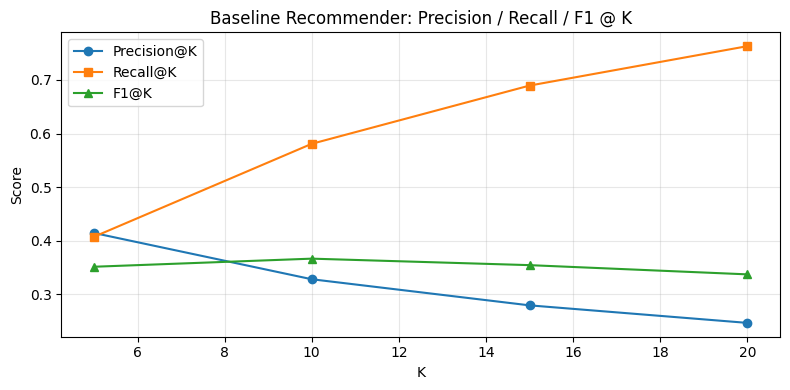

In [21]:
# Visualize Precision / Recall / F1 trade-off
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(results_df['K'], results_df['Precision@K'], 'o-', label='Precision@K')
ax.plot(results_df['K'], results_df['Recall@K'], 's-', label='Recall@K')
ax.plot(results_df['K'], results_df['F1@K'], '^-', label='F1@K')
ax.set_xlabel('K')
ax.set_ylabel('Score')
ax.set_title('Baseline Recommender: Precision / Recall / F1 @ K')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6) Predict for Test Orders
We generate candidate sets for users in the test set and score them.

In [15]:
test_orders = orders[orders['eval_set'] == 'test'][['order_id', 'user_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
test_candidates = test_orders[['order_id', 'user_id']].merge(user_prior, on='user_id', how='left')
test_df = test_candidates.merge(up, on=['user_id', 'product_id'], how='left')
test_df = test_df.merge(user_features, on='user_id', how='left')
test_df = test_df.merge(prod_features, on='product_id', how='left')
test_df = test_df.merge(test_orders, on=['order_id', 'user_id'], how='left')
test_df[feature_cols] = test_df[feature_cols].fillna(0)
test_preds = model.predict_proba(test_df[feature_cols])[:, 1]
test_df['pred'] = test_preds

In [16]:
def select_recommendations(df, prob_threshold=0.20, top_n=10):
    df = df.sort_values(['order_id', 'pred'], ascending=[True, False])
    recs = []
    for order_id, group in df.groupby('order_id'):
        filtered = group[group['pred'] >= prob_threshold]
        if filtered.empty:
            filtered = group.head(top_n)
        recs.append(
            pd.DataFrame({'order_id': order_id, 'product_id': filtered['product_id'].values})
        )
    return pd.concat(recs, ignore_index=True)

recommendations = select_recommendations(test_df)

In [17]:
recommendations.head()

,order_id,product_id
0,17,13107
1,34,16083
2,34,39475
3,34,47766
4,34,47792


# 7) Save Model

In [18]:
OPT_DIR = Path('..') / 'opt'
OPT_DIR.mkdir(parents=True, exist_ok=True)
model_path = OPT_DIR / 'xgb_recommender.json'
model.save_model(model_path)
print(f'Saved model to {model_path}')

Saved model to ../opt/xgb_recommender.json
